## We used 32 bytes Clustering Feature (LinearSum and SquareSum of every segment) from BIRCH article to summarize time series from 256 floating points to 8 floating points. Entire time series database compressed into an array (50000,8). 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import csv
import math
import struct

# Input data files are available in the "../input/" directory.

## initializing paths
inputFolderPath = '/kaggle/input/similarity-search-project/'
outputFolderPath = '/kaggle/working/'

inputFilePath_synthetic = inputFolderPath + 'synthetic_size50k_len256_znorm.bin'
inputFilePath_seismic = inputFolderPath + 'seismic_size50k_len256_znorm.bin'

queryFilePath_synthetic = inputFolderPath + 'synthetic-query_size100_len256_znorm.bin'
queryFilePath_seismic = inputFolderPath + 'seismic-query_size100_len256_znorm.bin'


### Summarize time series database to CF features

In [2]:
# size in bytes (128/64/32)
def compress_to_size(x, size):
    # calculate the number of segments
    n_segments = int(size/4/2) 
    piece_size = int(256/n_segments)
    com_x = np.array([], dtype = np.float32).reshape(x.shape[0], -1)
    for i in range(n_segments):
        sum_segment = np.sum(x[:, int(piece_size*i):int(piece_size*i+piece_size-1)], axis = 1)
        squaresum_segment = np.sum(np.square(x[:, int(piece_size*i):int(piece_size*i+piece_size-1)]), axis = 1)
        com_x = np.column_stack((com_x, sum_segment))
        com_x = np.column_stack((com_x, squaresum_segment))
    return com_x

In [3]:
def sum32(inputFilePath):
    time_series50k = np.fromfile(inputFilePath, dtype=np.float32).reshape(-1, 256)
    
    # compression
    summary50k = compress_to_size(time_series50k, 32)

    return summary50k

In [4]:
ts50k_synthetic = np.fromfile(inputFilePath_synthetic, dtype=np.float32).reshape(-1,256)
ts50k_seismic = np.fromfile(inputFilePath_seismic, dtype=np.float32).reshape(-1,256)

ts_query_synthetic = np.fromfile(queryFilePath_synthetic, dtype=np.float32).reshape(-1,256)
ts_query_seismic = np.fromfile(queryFilePath_seismic, dtype=np.float32).reshape(-1,256)

sum32_synthetic = sum32(inputFilePath_synthetic)
sum32_query_synthetic = sum32(queryFilePath_synthetic)
sum32_seismic = sum32(inputFilePath_seismic)
sum32_query_seismic = sum32(queryFilePath_seismic)

In [5]:
# An interface function to calculate Euclidean distance between 2 signals
def euc_dist(x,y):
    return float(np.linalg.norm(x - y))

## Generate K-Means clustering models based on LinearSum and SquareSum of 4 segments. 
#### We compared different numbers of cluster parameter, we figured out that K=3 reached higher Silhouette score than others (tried K = 3..10)

# Synthetic

### Create 4 KMeans clustering model for 4 segments

In [6]:
# Generate clustering models for synthetic database
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

seg1_synthetic = sum32_synthetic[:,0:2]
seg2_synthetic = sum32_synthetic[:,2:4]
seg3_synthetic = sum32_synthetic[:,4:6]
seg4_synthetic = sum32_synthetic[:,6:8]

n = 3
cluster1_synthetic = KMeans(n_clusters = n, init='k-means++', n_init = 5)
cluster1_synthetic.fit(seg1_synthetic)
cl1_silhouette = silhouette_score(seg1_synthetic, cluster1_synthetic.labels_)

cluster2_synthetic = KMeans(n_clusters = n, init='k-means++', n_init = 5)
cluster2_synthetic.fit(seg2_synthetic)
cl2_silhouette = silhouette_score(seg2_synthetic, cluster2_synthetic.labels_)

cluster3_synthetic = KMeans(n_clusters = n, init='k-means++', n_init = 5)
cluster3_synthetic.fit(seg3_synthetic)
cl3_silhouette = silhouette_score(seg3_synthetic, cluster3_synthetic.labels_)

cluster4_synthetic = KMeans(n_clusters = n, init='k-means++', n_init = 5)
cluster4_synthetic.fit(seg4_synthetic)
cl4_silhouette = silhouette_score(seg4_synthetic, cluster4_synthetic.labels_)

print(cl1_silhouette, cl2_silhouette, cl3_silhouette, cl4_silhouette)

0.51598835 0.45311028 0.4521914 0.5180586


In [7]:
# Predict labels for database
p_seg1 = cluster1_synthetic.predict(seg1_synthetic)
p_seg2 = cluster2_synthetic.predict(seg2_synthetic)
p_seg3 = cluster3_synthetic.predict(seg3_synthetic)
p_seg4 = cluster4_synthetic.predict(seg4_synthetic)

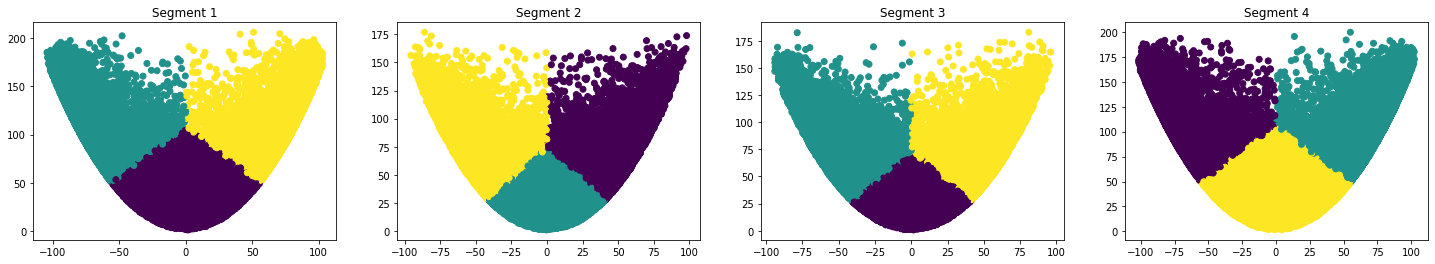

In [8]:
# Visualize clusters on 4 segments
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 4]
plt.subplot(141)
plt.scatter(seg1_synthetic[:, 0], seg1_synthetic[:, 1], c=p_seg1)
plt.title("Segment 1")
plt.subplot(142)
plt.scatter(seg2_synthetic[:, 0], seg2_synthetic[:, 1], c=p_seg2)
plt.title("Segment 2")
plt.subplot(143)
plt.scatter(seg3_synthetic[:, 0], seg3_synthetic[:, 1], c=p_seg3)
plt.title("Segment 3")
plt.subplot(144)
plt.scatter(seg4_synthetic[:, 0], seg4_synthetic[:, 1], c=p_seg4)
plt.title("Segment 4")
plt.show()

### Similairty search with generated KMeans models for synthetic time series

In [9]:
# Initialize Euclidean distance between query and the most similar from database as positive infinity
D_closest = 1000.0

# Initialize the closest index as 0
i_similar = 0

# Initialize counter as 0
count = 0

# Loop query
for i in range(100):
    
    # Use the cluster to predict the 4 segments of the query
    qf_class1 = cluster1_synthetic.predict(sum32_query_synthetic[i,0:2].reshape(1,2))
    qf_class2 = cluster2_synthetic.predict(sum32_query_synthetic[i,2:4].reshape(1,2))
    qf_class3 = cluster3_synthetic.predict(sum32_query_synthetic[i,4:6].reshape(1,2))
    qf_class4 = cluster4_synthetic.predict(sum32_query_synthetic[i,6:8].reshape(1,2))
    
    # If the 4 segments' cluster indexes are equal between the query and a time series of database
    for j in range(50000):
        
        similarity_count = 0
        if (p_seg1[j] == qf_class1):
            similarity_count += 1
        if (p_seg2[j] == qf_class2): 
            similarity_count += 1
        if (p_seg3[j] == qf_class3): 
            similarity_count += 1
        if (p_seg4[j] == qf_class4):
            similarity_count += 1
            
        # I tried 1/2/3/4, got results(average NOT pruned count for every query) : 46493.27 / 29782.3 / 5262.5 / 229.2
        # Based on the test, choose the best match :) 
        if (similarity_count == 4):
            # count NOT pruned time series.
            count += 1
            # Calculate the Euclidean distance between original size time series
            d = euc_dist(ts50k_synthetic[j,], ts_query_synthetic[i, ])

            if (d < D_closest):
                D_closest = d
                i_similar = i

# ratio = (50000 - NOT_pruned) / 50000, here [count] is sum of 100 queries, so I divided 100
pruning_ratio_synthetic = (50000 - count/100) / 50000

# Seismic

### Create 4 KMeans clustering model for 4 segments

In [10]:
# Generate clustering models for seismic database
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

seg1_seismic = sum32_seismic[:,0:2]
seg2_seismic = sum32_seismic[:,2:4]
seg3_seismic = sum32_seismic[:,4:6]
seg4_seismic = sum32_seismic[:,6:8]

n = 3
cluster1_seismic = KMeans(n_clusters = n, init='k-means++', n_init = 5)
cluster1_seismic.fit(seg1_seismic)
cl1_silhouette = silhouette_score(seg1_seismic, cluster1_seismic.labels_)

cluster2_seismic = KMeans(n_clusters = n, init='k-means++', n_init = 5)
cluster2_seismic.fit(seg2_seismic)
cl2_silhouette = silhouette_score(seg2_seismic, cluster2_seismic.labels_)

cluster3_seismic = KMeans(n_clusters = n, init='k-means++', n_init = 5)
cluster3_seismic.fit(seg3_seismic)
cl3_silhouette = silhouette_score(seg3_seismic, cluster3_seismic.labels_)

cluster4_seismic = KMeans(n_clusters = n, init='k-means++', n_init = 5)
cluster4_seismic.fit(seg4_seismic)
cl4_silhouette = silhouette_score(seg4_seismic, cluster4_seismic.labels_)

print(cl1_silhouette, cl2_silhouette, cl3_silhouette, cl4_silhouette)

0.47515526 0.48589927 0.48460156 0.47260925


In [11]:
# Predict labels for database
p_seg1 = cluster1_seismic.predict(seg1_seismic)
p_seg2 = cluster2_seismic.predict(seg2_seismic)
p_seg3 = cluster3_seismic.predict(seg3_seismic)
p_seg4 = cluster4_seismic.predict(seg4_seismic)

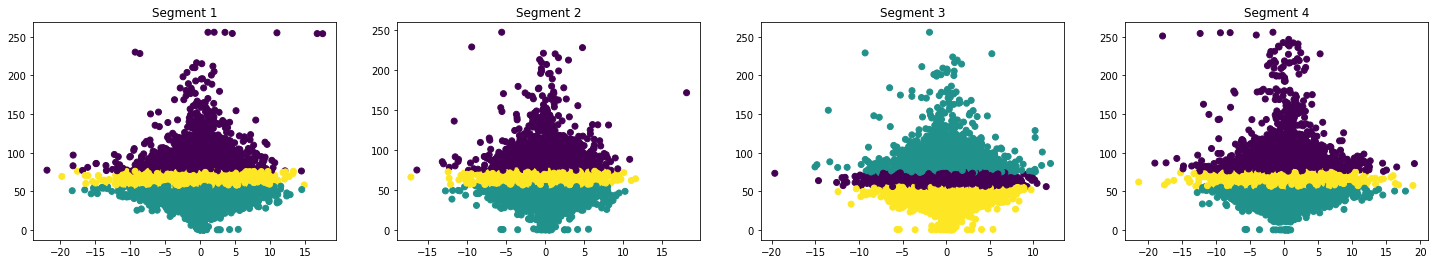

In [12]:
# Visualize clusters on 4 segments
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 4]
plt.subplot(141)
plt.scatter(seg1_seismic[:, 0], seg1_seismic[:, 1], c=p_seg1)
plt.title("Segment 1")
plt.subplot(142)
plt.scatter(seg2_seismic[:, 0], seg2_seismic[:, 1], c=p_seg2)
plt.title("Segment 2")
plt.subplot(143)
plt.scatter(seg3_seismic[:, 0], seg3_seismic[:, 1], c=p_seg3)
plt.title("Segment 3")
plt.subplot(144)
plt.scatter(seg4_seismic[:, 0], seg4_seismic[:, 1], c=p_seg4)
plt.title("Segment 4")
plt.show()

### Similairty search with generated KMeans models for synthetic time series

In [13]:
# Initialize Euclidean distance between query and the most similar from database as positive infinity
D_closest = 1000.0

# Initialize the closest index as 0
i_similar = 0

# Initialize counter as 0
count = 0

# Loop query
for i in range(100):
    
    # Use the cluster to predict the 4 segments of the query
    qf_class1 = cluster1_seismic.predict(sum32_query_seismic[i,0:2].reshape(1,2))
    qf_class2 = cluster2_seismic.predict(sum32_query_seismic[i,2:4].reshape(1,2))
    qf_class3 = cluster3_seismic.predict(sum32_query_seismic[i,4:6].reshape(1,2))
    qf_class4 = cluster4_seismic.predict(sum32_query_seismic[i,6:8].reshape(1,2))
    
    # If the 4 segments' cluster indexes are equal between the query and a time series of database
    for j in range(50000):
        
        similarity_count = 0
        if (p_seg1[j] == qf_class1):
            similarity_count += 1
        if (p_seg2[j] == qf_class2): 
            similarity_count += 1
        if (p_seg3[j] == qf_class3): 
            similarity_count += 1
        if (p_seg4[j] == qf_class4):
            similarity_count += 1
        
        # Based on the test, choose the best match :) 
        if (similarity_count == 4):
            # count NOT pruned time series.
            count += 1
            # Calculate the Euclidean distance between original size time series
            d = euc_dist(ts50k_seismic[j,], ts_query_seismic[i, ])

            if (d < D_closest):
                D_closest = d
                i_similar = i

# ratio = (50000 - NOT_pruned) / 50000, here [count] is sum of 100 queries, so I divided 100
pruning_ratio_seismic = (50000 - count/100) / 50000

In [14]:
pruning_ratio_seismic, pruning_ratio_synthetic

(0.9611944, 0.9954076)

In [15]:
(pruning_ratio_seismic + pruning_ratio_synthetic) / 2

0.978301

In [16]:
def similarity():
    return (pruning_ratio_seismic + pruning_ratio_synthetic) / 2

In [17]:
########################## Submission ################################################
############ follow this templateand do not modify this cell code ####################

#call of similatrity search function 
average_prune_ratio = similarity()

with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id','expected'])
    writer.writerow(['1',average_prune_ratio])